In [1]:
from image_processing.image_utils import *
import pandas as pd
import os
import shutil

In [2]:
preds_dir = '/home/rmccune/depth_mapping/CB03_all_photos/test_segs'
labels_dir = '/home/rmccune/depth_mapping/CB03_all_photos/test_labls'

In [3]:
create_labels_from_predsegs(preds_dir, labels_dir, use_gpu=False)

Generating labels from predictions:   0%|          | 0/137 [00:00<?, ?it/s]

Generating labels from predictions: 100%|██████████| 137/137 [00:17<00:00,  7.85it/s]


In [5]:
create_labels_from_predsegs(preds_dir, labels_dir, use_gpu=True, batch_size=100)

Generating labels from predictions: 100%|██████████| 137/137 [00:18<00:00,  7.57it/s]


Separate Water Levels into separate csvs per flood event

In [2]:
# Load the abbreviated flood events and full data records
abbr_flood_events = pd.read_csv('/home/rmccune/depth_mapping/CB_03_flood_record/abbr_flood_events.csv')
flood_events = pd.read_csv('/home/rmccune/depth_mapping/CB_03_flood_record/flood_events.csv')

# Ensure the output directory exists
output_dir = 'output_flood_events'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Convert the start and end time columns to datetime
abbr_flood_events['start_time_UTC'] = pd.to_datetime(abbr_flood_events['start_time_UTC'], utc=True)
abbr_flood_events['end_time_UTC'] = pd.to_datetime(abbr_flood_events['end_time_UTC'], utc=True)

# Format datetime to string for folder naming
abbr_flood_events['start_time_str'] = abbr_flood_events['start_time_UTC'].dt.strftime('%Y%m%d%H%M%S')
abbr_flood_events['end_time_str'] = abbr_flood_events['end_time_UTC'].dt.strftime('%Y%m%d%H%M%S')

# Iterate over each unique flood event in the abbreviated events
for _, row in abbr_flood_events.iterrows():
    flood_event_number = row['flood_event']
    start_time_utc = row['start_time_str']
    end_time_utc = row['end_time_str']
    
    sensor_id = row['sensor_ID']
    
    # Filter the full flood events DataFrame for the current flood event number
    filtered_events = flood_events[flood_events['flood_event'] == flood_event_number]
    
    # Generate a filename based on start_time_UTC and end_time_UTC
    filename = f"{sensor_id}_{start_time_utc}_{end_time_utc}.csv"
    
    # Save the filtered DataFrame to a new CSV file
    filtered_events.to_csv(os.path.join(output_dir, filename), index=False)

print(f"Successfully created CSV files in '{output_dir}' directory.")

Successfully created CSV files in 'output_flood_events' directory.


Move csvs into proper subfolders

In [5]:
# Define the main directory where the output CSV files are located
main_directory = 'output_flood_events'
# Define the parent directory where you want to create subfolders
parent_directory = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events'  # Change this to your actual parent directory

# Iterate over the files in the main directory
for filename in os.listdir(main_directory):
    if filename.endswith('.csv'):
        # Extract the folder name from the filename (without the .csv extension)
        folder_name = filename[:-4]  # Remove '.csv' from the filename
        
        # Create the full path for the subfolder
        subfolder_path = os.path.join(parent_directory, folder_name)
        
        # Create the subfolder if it doesn't exist
        os.makedirs(subfolder_path, exist_ok=True)
        
        # Move the CSV file to the corresponding subfolder
        source_path = os.path.join(main_directory, filename)
        destination_path = os.path.join(subfolder_path, filename)
        shutil.move(source_path, destination_path)

print("CSV files have been moved to their corresponding subfolders.")


CSV files have been moved to their corresponding subfolders.


In [2]:
import numpy as np 
import cupy as cp
import cupyx as cpx
import time
import cv2
import zarr

# from gpu_acc_utils import *
from cupyx.scipy.interpolate import RegularGridInterpolator as reg_interp
from cupyx.scipy.ndimage import binary_closing
from cupyx.scipy.ndimage import label
from skimage.measure import find_contours
import image_processing

In [2]:
file_path = '/home/rmccune/depth_mapping/data/lidar/Job1051007_34077_04_88.laz'

min_x_extent = 712160
max_x_extent = 712230
min_y_extent = 33100
max_y_extent = 33170

grid_gen = image_processing.GridGenerator(file_path, min_x_extent, max_x_extent, min_y_extent, max_y_extent)

In [3]:
resolution = 0.05 # meters

pts_array = grid_gen.create_point_array()
grid_x, grid_y, grid_z = grid_gen.gen_grid(resolution, z=pts_array)

grid_z_gpu = cp.asarray(grid_z)

Directory to store grids already exists: generated_grids


In [4]:
from image_processing.depth_mapper import DepthMapper

In [7]:
zarr_directory_path = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events/CB_03_20220617023112_20220617040940/zarr/labels_rects'
zarr_store_path = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events/CB_03_20220617023112_20220617040940/zarr/depth_maps_95th_ponding_OOP_debug_save'

mapper = DepthMapper(grid_z_gpu)

In [ ]:
mapper.process_depth_maps(zarr_directory_path, zarr_store_path)

In [3]:
import os
import zarr
import matplotlib.pyplot as plt
import cmocean

In [8]:
def plot_depth_maps(zarr_dir, plotting_folder, depth_min=0, depth_max=0.25):

    depth_data = []

    for file_name in os.listdir(zarr_dir):
        if file_name.endswith('_ponding'):
            zarr_store_path = os.path.join(zarr_dir, file_name)
            img_store = zarr.open(zarr_store_path)
            
            depth_map = img_store[:]
            
            print(f"Processing depth map: {file_name}")

            # Overlay the depth map
            im = plt.imshow(depth_map, cmap=cmocean.cm.deep, vmin=depth_min, vmax=depth_max)  # Adjust alpha for transparency
            # print(f"Vmin:{depth_min} Vmax: {depth_max} Max depth: {np.nanmax(depth_map)} Min depth: {np.nanmin(depth_map)}")

            # plt.scatter(max_elev_point_indices[1], max_elev_point_indices[0], c='red', s=10, marker='o')

            # Add a colorbar for the depth map
            cbar = plt.colorbar(im, label='Depth')
            cbar.set_label('Depth (meters)')

            plt.gca().invert_yaxis()
            plt.xlabel('X (cm)')
            plt.ylabel('Y (cm)')

            # Save the figure
            plt.savefig(os.path.join(plotting_folder, file_name), 
                        bbox_inches='tight', pad_inches=0.1, dpi=300)
            
            plt.close()

In [9]:
zarr_store_path = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events/CB_03_20220617023112_20220617040940/zarr/depth_maps_95th_ponding_OOP_debug_save'
plot_depth_maps(zarr_store_path, '/home/rmccune/depth_mapping_updated/plots/depth_maps_95th_ponding_OOP_debug_save')

Processing depth map: CAM_CB_03_20220617023633_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617033032_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617033631_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617035433_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617032434_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617040633_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617034232_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617030630_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617025433_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617040032_predseg_labels_rectified_d

In [4]:
import os
from tqdm import tqdm

Process depth maps for all flood events in main directory/

In [ ]:
# Path to the main directory containing subfolders
main_directory = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events'

# # Iterate through each subfolder in the main directory
# for subfolder in os.listdir(main_directory):
#     subfolder_path = os.path.join(main_directory, subfolder)
    
#     # Check if it is a directory
#     if os.path.isdir(subfolder_path):
#         labels_rects_zarr_folder = os.path.join(subfolder_path, 'zarr', 'labels_rects')
        
#         # Check if the orig_images and labels folders exist
#         if os.path.exists(labels_rects_zarr_folder):
#             depth_map_zarr_save_dir = os.path.join(subfolder_path, 'zarr', 'depth_maps_95th_ponding')
#             mapper.process_depth_maps(labels_rects_zarr_folder, depth_map_zarr_save_dir)

# Get a list of subfolders
subfolders = [f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))]

# Iterate through each subfolder with a progress bar
for subfolder in tqdm(subfolders, desc="Processing flood events", unit="event"):
    subfolder_path = os.path.join(main_directory, subfolder)
    labels_rects_zarr_folder = os.path.join(subfolder_path, 'zarr', 'labels_rects')
    
    # Check if the labels_rects folder exists
    if os.path.exists(labels_rects_zarr_folder):
        # print(f"Processing folder {subfolder}.")
        depth_map_zarr_save_dir = os.path.join(subfolder_path, 'zarr', 'depth_maps_95th_ponding')
        mapper.process_depth_maps(labels_rects_zarr_folder, depth_map_zarr_save_dir)

# Plot Depth Maps with Water Levels

In [1]:
def plot_depth_maps_and_water_lvls(depth_map_zarr_dir, orig_image_zarr_dir, virtual_sensor_locs, datetimes, results_df, plotting_folder, vs_depth_list, depth_min=0, depth_max=0.25):

    depth_data = []

    for file_name in sorted(os.listdir(depth_map_zarr_dir)):
        if file_name.endswith('_ponding'):
            
            timestamp = image_processing.image_utils.extract_timestamp(file_name)
            date = pd.to_datetime(timestamp, utc=True)
            orig_file_name = None
            for f in os.listdir(orig_image_zarr_dir):
                if image_processing.image_utils.extract_timestamp(f) == timestamp:
                    orig_file_name = f
                    break
            
            if orig_file_name is None:
                print(f"Warning: No matching original image found for {file_name}")
                continue
            
            orig_zarr_store_path = os.path.join(orig_image_zarr_dir, orig_file_name)
            orig_img_store = zarr.open(orig_zarr_store_path, mode='r')
            orig_image = orig_img_store[:]
            
            zarr_store_path = os.path.join(depth_map_zarr_dir, file_name)
            img_store = zarr.open(zarr_store_path)
            
            depth_map = img_store[:]
            
            print(f"Processing depth map: {file_name}")

            fig = plt.figure(figsize=(12, 12))

            # Create a GridSpec with 3 rows and 1 column, where the first row is larger
            # gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1])
            gs = fig.add_gridspec(2, 1, height_ratios=[1.5, 1])

            ax1 = fig.add_subplot(gs[0])
            ax1.imshow(orig_image, cmap='gray')  # Assuming ir_array is your grayscale image
            im = ax1.imshow(depth_map, cmap=cmocean.cm.deep, vmin=depth_min, vmax=depth_max)  # Adjust alpha for transparency
            ax1.scatter(virtual_sensor_locs[0][0], virtual_sensor_locs[0][1], color=sensor_1_color, s=15, marker='v')
            ax1.scatter(virtual_sensor_locs[1][0], virtual_sensor_locs[1][1], color=sensor_2_color, s=15, marker='s')
            ax1.scatter(virtual_sensor_locs[2][0], virtual_sensor_locs[2][1], color=sensor_3_color, s=15, marker='d')
            cbar = plt.colorbar(im, label='Depth')
            cbar.set_label('Depth (m)')
            ax1.invert_yaxis()
            ax1.set_xlabel('X (cm)')
            ax1.set_ylabel('Y (cm)')

            ax1.text(0.05, 0.95, f'Spatial Extent ($m^2$): {round((np.sum(~np.isnan(depth_map))) * 0.0001 * 10 * 10, 2)}', 
                     transform=ax1.transAxes, 
                     fontsize=12, 
                     verticalalignment='top', 
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

            # ax2 = fig.add_subplot(gs[1])
            # ax2.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
            # ax2.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
            #          c='k', linestyle='--', label='Roadway Elevation')

            # # Plotting the max and average depth
            # ax2.plot(datetimes, max_depth_list, label='Maximum Depth', linestyle='-', color=max_depth_color)
            # ax2.plot(datetimes, avg_depth_list, label='Average Depth', linestyle='-.', color=avg_depth_color)
            # ax2.axvline(x=date, color='k', linestyle='-')

            # ax3 = fig.add_subplot(gs[2], sharex=ax2, sharey=ax2)
            ax3 = fig.add_subplot(gs[1])
            
            ax3.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
            # ax3.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
            #          c='k', linestyle='--', label='Roadway Elevation')

            # Plotting the sensor readings
            # ax3.scatter(datetimes, vs_3_depth_list, label='Sensor 1 Depth', marker='d', color=sensor_3_color, s=10)
            # ax3.scatter(datetimes, vs_1_depth_list, label='Sensor 2 Depth',  marker='v', color=sensor_1_color, s=10)
            # ax3.scatter(datetimes, vs_2_depth_list, label='Sensor 3 Depth', marker='s', color=sensor_2_color, s=10)
            ax3.scatter(datetimes, vs_depth_list[2], label='Sensor 1 Depth', marker='d', color=sensor_3_color, s=10)
            ax3.scatter(datetimes, vs_depth_list[0], label='Sensor 2 Depth',  marker='v', color=sensor_1_color, s=10)
            ax3.scatter(datetimes, vs_depth_list[1], label='Sensor 3 Depth', marker='s', color=sensor_2_color, s=10)
            
            
            ax3.axvline(x=date, color='k', linestyle='-', zorder=1)
            # ax3.scatter(date, vs_1_depth, marker='v', color=sensor_1_color, s=20, zorder=2)
            # ax3.scatter(date, vs_2_depth, marker='s', color=sensor_2_color, s=20, zorder=2)
            # ax3.scatter(date, vs_3_depth, marker='d', color=sensor_3_color, s=20, zorder=2)
            # ax2.set_ylim(-0.25,0.75)
            ax3.set_ylim(-0.25,0.75)

            # Axis labels and title
            # ax2.set_xlabel('Time')
            # ax2.tick_params(axis='x', rotation=45)
            ax3.tick_params(axis='x', rotation=45)
            # ax3.set_xticklabels(ax3.get_xticks(), rotation=45)
            # ax2.set_ylabel('Water Level Relative to Roadway (m)')
            # ax2.set_title('Water Level and Depth Measurements Over Time')
            ax3.set_title('Water Level From Virtual Sensor Locations Over Time')
            ax3.set_ylabel('Water Depth (m)')

            # Adding gridlines
            # ax2.grid(True)
            ax3.grid(True)

            # ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Adjust format as needed

            # Adding legend outside of the figure bounds
            # ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            # ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            ax3.legend(loc='upper right')

            plt.tight_layout()
            
            # Save the figure
            plt.savefig(os.path.join(plotting_folder, file_name), 
                        bbox_inches='tight', pad_inches=0.1, dpi=300)
            
            plt.close()
            img_store.store.close()

In [9]:
import os
import pandas as pd
import image_processing
import pytz
from datetime import datetime
import cmocean
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
water_level_color = cmocean.cm.balance(0.2)
# roadway_elevation_color = cmocean.cm.deep(0.7)
max_depth_color = cmocean.cm.balance(0.9)
avg_depth_color = cmocean.cm.balance(0.6)
sensor_1_color = cmocean.cm.phase(0.1)
sensor_2_color = cmocean.cm.phase(0.3)
sensor_3_color = cmocean.cm.phase(0.5)

virtual_sensor_locs = np.array([[125, 390], 
                       [75, 440],
                       [5, 370],
                       [9, 355]])

virtual_sensor_locs = virtual_sensor_locs * 2

# Path to the main directory containing subfolders
main_directory = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events'

# Get a list of subfolders
flood_events_folders = [f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))]

# Iterate through each subfolder with a progress bar
for flood_event in tqdm(flood_events_folders, desc="Plotting depth maps for flood events...", unit="event"):
    flood_event_path = os.path.join(main_directory, flood_event)
    
    sunnyd_data = pd.read_csv(os.path.join(flood_event_path, flood_event + '.csv'))
    sunnyd_data['time_UTC'] = pd.to_datetime(sunnyd_data['time_UTC'])
    
    orig_images_path = os.path.join(flood_event_path, 'orig_images')
    image_list = sorted(os.listdir(orig_images_path))
    results = []

    # Iterate over image filenames
    for filename in image_list:
        # Extract the sensor id and timestamp
        sensor_id = image_processing.image_utils.extract_camera_name(filename)[4:]
        timestamp = image_processing.image_utils.extract_timestamp(filename)

        timestamp = pytz.utc.localize(datetime.strptime(timestamp, "%Y%m%d%H%M%S"))
        
        # Filter the dataframe by sensor id
        filtered_df = sunnyd_data[sunnyd_data['sensor_ID'] == sensor_id]
        
        # Find the closest timestamp
        closest_row = filtered_df.iloc[(filtered_df['time_UTC'] - timestamp).abs().argsort()[:1]]
        
        # Append the result
        if not closest_row.empty:
            result = {
                'image_filename': filename,
                'closest_utc_time': closest_row['time_UTC'].values[0],
                'water_level': closest_row['water_level'].values[0] * 0.3048
                # 'sensor_water_level': (closest_row['sensor_water_level_adj'].values[0] - 3.05) * 0.3048
            }
            results.append(result)

    # Convert the results to a dataframe
    results_df = pd.DataFrame(results)
    
    depth_maps_zarr_folder = os.path.join(flood_event_path, 'zarr', 'depth_maps_95th_ponding')
    orig_images_zarr_folder = os.path.join(flood_event_path, 'zarr', 'orig_image_rects')
    
    max_depth_list = []
    timestamp_list = []
    avg_depth_list = []
    vs_1_depth_list = []
    vs_2_depth_list = []
    vs_3_depth_list = []
    vs_4_depth_list = []
    
    if os.path.exists(depth_maps_zarr_folder):
        for file_name in os.listdir(depth_maps_zarr_folder):
            if file_name.endswith('_ponding'):
                timestamp = image_processing.image_utils.extract_timestamp(file_name)
                zarr_store_path = os.path.join(depth_maps_zarr_folder, file_name)
                img_store = zarr.open(zarr_store_path)
                
                depth_map = img_store[:]
                
                # max_elev_point_indices = np.unravel_index(np.nanargmin(depth_map), depth_map.shape)
            
                max_depth = np.nanmax(depth_map)
                avg_depth = np.nanmean(depth_map)

                vs_1_depth = depth_map[virtual_sensor_locs[0][1], virtual_sensor_locs[0][0]]
                vs_2_depth = depth_map[virtual_sensor_locs[1][1], virtual_sensor_locs[1][0]]
                vs_3_depth = depth_map[virtual_sensor_locs[2][1], virtual_sensor_locs[2][0]]
                vs_4_depth = depth_map[virtual_sensor_locs[3][1], virtual_sensor_locs[3][0]]

                timestamp_list.append(timestamp)
                max_depth_list.append(max_depth)
                avg_depth_list.append(avg_depth)
                vs_1_depth_list.append(vs_1_depth)
                vs_2_depth_list.append(vs_2_depth)
                vs_3_depth_list.append(vs_3_depth)
                # vs_4_depth_list.append(vs_4_depth)
        
        datetimes = pd.to_datetime(timestamp_list, utc=True)
        
        plotting_folder = os.path.join(flood_event_path, 'plots', 'depth_maps_95th_perc_ponding_w_background')
        os.makedirs(plotting_folder, exist_ok=True)
        plot_depth_maps_and_water_lvls(depth_maps_zarr_folder, orig_images_zarr_folder, virtual_sensor_locs, datetimes, results_df, plotting_folder)


In [7]:
import os
import zarr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
zarr_store_path = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events/CB_03_20230707033307_20230707050907/zarr/virtual_sensor_depths'
        
if os.path.exists(zarr_store_path):
    root = zarr.open(zarr_store_path, mode='r')

    timestamps = root["timestamps"][:]  # Load as an array of strings
    max_depths = root["max_depths"][:]
    avg_depths = root["avg_depths"][:]
    vs_depths = root["vs_depths"][:]

    # Convert timestamps back to pandas datetime
    datetimes = pd.to_datetime(timestamps, utc=True)

/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


In [9]:
vs_depths.shape

(16, 4)

In [10]:
random_array = np.random.rand(*datetimes.shape)

In [11]:
random_array.shape

(16,)

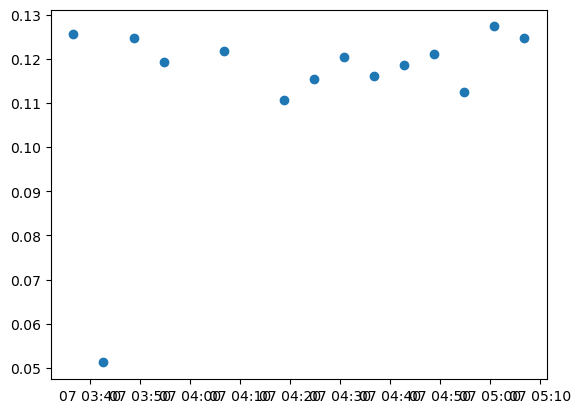

In [12]:
plt.scatter(datetimes, vs_depths[:,0])
plt.show()

In [13]:
obs_to_img_matches = pd.read_csv('/home/rmccune/depth_mapping/CB03_all_photos/flood_events/CB_03_20230707033307_20230707050907/wtr_lvl_obs_to_image_matches.csv')

In [14]:
obs_to_img_matches

,Unnamed: 0,image_filename,closest_utc_time,water_level
0,0,CAM_CB_03_20230707033643.jpg,2023-07-07 03:39:07,0.012613
1,1,CAM_CB_03_20230707034244.jpg,2023-07-07 03:45:07,0.021044
2,2,CAM_CB_03_20230707034847.jpg,2023-07-07 03:51:07,0.025457
3,3,CAM_CB_03_20230707035446.jpg,2023-07-07 03:57:07,0.028767
4,4,CAM_CB_03_20230707040046.jpg,2023-07-07 04:03:07,0.046906
5,5,CAM_CB_03_20230707040646.jpg,2023-07-07 04:09:07,0.055005
6,6,CAM_CB_03_20230707041247.jpg,2023-07-07 04:15:07,0.059154
7,7,CAM_CB_03_20230707041847.jpg,2023-07-07 04:21:07,0.061774
8,8,CAM_CB_03_20230707042446.jpg,2023-07-07 04:27:07,0.061138
9,9,CAM_CB_03_20230707043046.jpg,2023-07-07 04:33:07,0.060106


In [1]:
import numpy as np

In [2]:
main_directory = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events'
virtual_sensor_locs = np.array([[125, 390], [75, 440], [5, 370], [9, 355]]) * 2

In [3]:
from depth_plotter import DepthPlotter

In [4]:
plotter = DepthPlotter(main_directory, virtual_sensor_locs)

Plotting flood events...:   0%|          | 0/55 [00:00<?, ?event/s]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 28
Sensor data length: 28
Processing depth map: CAM_CB_03_20230929003045_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929003646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929004246_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929004845_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929005445_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929010044_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929010646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929011245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929011845_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:   2%|▏         | 1/55 [00:39<35:45, 39.73s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 5
Sensor data length: 5
Processing depth map: CAM_CB_03_20240109225430_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109230031_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109230630_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109231231_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109231831_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting flood events...:   4%|▎         | 2/55 [00:46<18:05, 20.48s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 19
Sensor data length: 19
Processing depth map: CAM_CB_03_20231016141825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016142425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016143025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016143625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016144225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016144825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016145425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016150025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016150625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:   5%|▌         | 3/55 [01:15<20:55, 24.14s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 21
Sensor data length: 21
Processing depth map: CAM_CB_03_20230927234245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230927234846_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230927235443_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928000046_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928000646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928001245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928001846_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928002446_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928003045_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:   7%|▋         | 4/55 [01:47<23:14, 27.34s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 72
Sensor data length: 72
Processing depth map: CAM_CB_03_20231217150625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217151225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217151826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217152425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217153025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217153625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217154225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217154825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217155425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:   9%|▉         | 5/55 [03:43<49:23, 59.28s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 25
Sensor data length: 25
Processing depth map: CAM_CB_03_20230929125425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929130025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929130625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929131225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929131825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929132425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929133025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929133625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929134225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:  11%|█         | 6/55 [04:29<44:46, 54.82s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 12
Sensor data length: 12
Processing depth map: CAM_CB_03_20230901015445_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901020041_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901020642_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901021245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901021845_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901022439_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901023045_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901023645_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901024246_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:  13%|█▎        | 7/55 [04:53<35:50, 44.81s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 86
Sensor data length: 86
Processing depth map: CAM_CB_03_20241114111956_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114112405_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114113220_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114113628_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114103_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114133_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114203_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114233_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114303_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:  15%|█▍        | 8/55 [07:36<1:04:26, 82.26s/event]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


datetime64[ns, UTC]
Datetimes length: 89
Sensor data length: 89
Processing depth map: CAM_CB_03_20220930132426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930133026_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930133626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930134226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930134826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930135425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930140025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930140626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930141226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processin

Plotting flood events...:  15%|█▍        | 8/55 [10:43<1:02:59, 80.42s/event]


KeyboardInterrupt: 

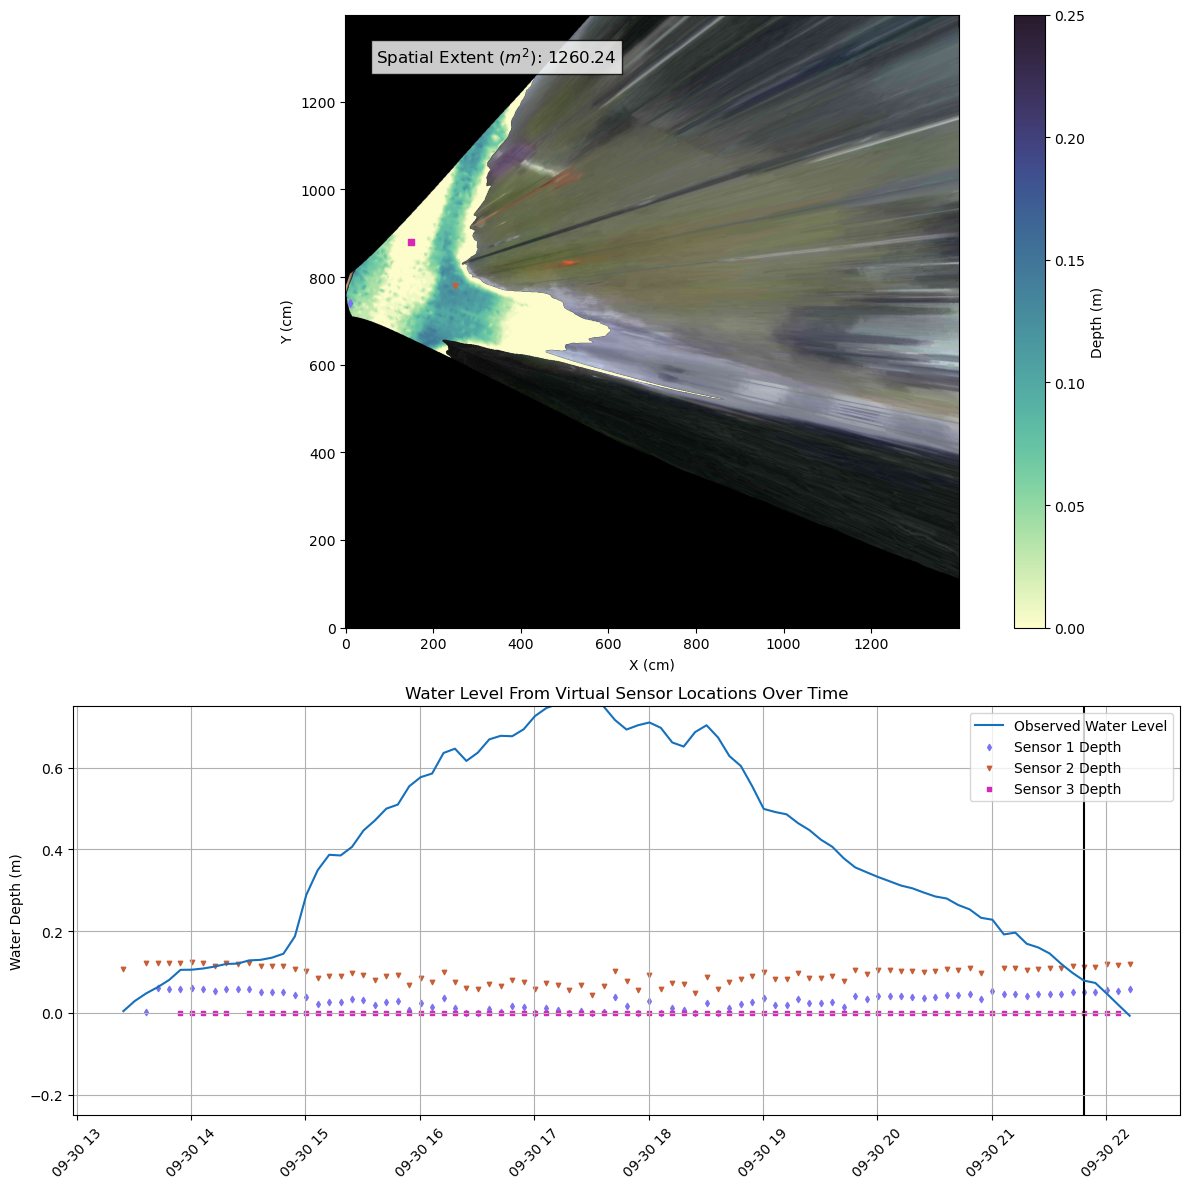

In [5]:
plotter.process_flood_events('depth_maps_test_plotting')

In [6]:
datetimes

NameError: name 'datetimes' is not defined

In [6]:
plotter.preprocess_flood_events()

Preprocessing flood events for plotting...:   0%|          | 0/55 [00:00<?, ?event/s]

/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/core/chunk_grids.py:74: RuntimeWarning: divide by zero encountered in log10
  target_size = increment_bytes * (2 ** np.log10(dset_size / (1024.0 * 1024)))
/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages/zarr/core/array.py:3985: UserWarning: The dtype `<U0` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
Preprocessing flood events for plotting...:   2%|▏         | 1/55 [00:00<00:42,  1.27event/s]/home/rmccune/miniconda3/envs/gpu_acc/lib/python3.12/site-packages

In [2]:
import os
import gc
import numpy as np
import pandas as pd
import pytz
import zarr
from tqdm import tqdm
from datetime import datetime
import cmocean
import matplotlib.pyplot as plt
import image_processing

# Define colors
water_level_color = cmocean.cm.balance(0.2)
max_depth_color = cmocean.cm.balance(0.9)
avg_depth_color = cmocean.cm.balance(0.6)
sensor_1_color = cmocean.cm.phase(0.1)
sensor_2_color = cmocean.cm.phase(0.3)
sensor_3_color = cmocean.cm.phase(0.5)

# Virtual sensor locations (scaled)
virtual_sensor_locs = np.array([[125, 390], [75, 440], [5, 370], [9, 355]]) * 2

# Main directory path
main_directory = '/home/rmccune/depth_mapping/CB03_all_photos/flood_events'

# Get subfolders (flood events)
flood_events_folders = [f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))]

# Process each flood event
for flood_event in tqdm(flood_events_folders, desc="Plotting depth maps for flood events..."):
    flood_event_path = os.path.join(main_directory, flood_event)
    
    # Load CSV data
    sunnyd_data = pd.read_csv(os.path.join(flood_event_path, flood_event + '.csv'))
    sunnyd_data['time_UTC'] = pd.to_datetime(sunnyd_data['time_UTC'])
    
    orig_images_path = os.path.join(flood_event_path, 'orig_images')
    image_list = sorted(os.listdir(orig_images_path))
    results = []
    
    for filename in image_list:
        sensor_id = image_processing.image_utils.extract_camera_name(filename)[4:]
        timestamp = image_processing.image_utils.extract_timestamp(filename)
        timestamp = pytz.utc.localize(datetime.strptime(timestamp, "%Y%m%d%H%M%S"))
        
        filtered_df = sunnyd_data[sunnyd_data['sensor_ID'] == sensor_id]
        closest_row = filtered_df.iloc[(filtered_df['time_UTC'] - timestamp).abs().argsort()[:1]]
        
        if not closest_row.empty:
            results.append({
                'image_filename': filename,
                'closest_utc_time': closest_row['time_UTC'].values[0],
                'water_level': closest_row['water_level'].values[0] * 0.3048
            })
    
    results_df = pd.DataFrame(results)
    depth_maps_zarr_folder = os.path.join(flood_event_path, 'zarr', 'depth_maps_95th_ponding')
    orig_images_zarr_folder = os.path.join(flood_event_path, 'zarr', 'orig_image_rects')
    
    max_depth_list, avg_depth_list, vs_depth_list = [], [], [[] for _ in range(4)]
    timestamp_list = []
    
    if os.path.exists(depth_maps_zarr_folder):
        for file_name in os.listdir(depth_maps_zarr_folder):
            if file_name.endswith('_ponding'):
                timestamp = image_processing.image_utils.extract_timestamp(file_name)
                zarr_store_path = os.path.join(depth_maps_zarr_folder, file_name)
                
                # Load Zarr lazily to avoid memory issues
                img_store = zarr.open(zarr_store_path, mode='r')
                depth_map = np.nan_to_num(img_store[:], nan=0.0)  # Replace NaNs to reduce computation issues
                
                max_depth_list.append(np.nanmax(depth_map))
                avg_depth_list.append(np.nanmean(depth_map))
                
                for i, (x, y) in enumerate(virtual_sensor_locs):
                    vs_depth_list[i].append(depth_map[y, x])
                
                timestamp_list.append(timestamp)
                
                img_store.store.close()
                
                # Free memory
                del depth_map
                gc.collect()
        
        datetimes = pd.to_datetime(timestamp_list, utc=True)
        plotting_folder = os.path.join(flood_event_path, 'plots', 'depth_maps_95th_perc_ponding_w_background')
        os.makedirs(plotting_folder, exist_ok=True)
        
        plot_depth_maps_and_water_lvls(
            depth_maps_zarr_folder, orig_images_zarr_folder, virtual_sensor_locs, datetimes, results_df, plotting_folder, vs_depth_list
        )
    
    depth_map = None  # Break references
    pd.DataFrame().to_csv('/dev/null')  # Force Pandas to release memory
    
    # Final memory cleanup
    gc.collect()


Plotting depth maps for flood events...:   0%|          | 0/55 [00:00<?, ?it/s]

Processing depth map: CAM_CB_03_20230929003045_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929003646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929004246_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929004845_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929005445_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929010044_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929010646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929011245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929011845_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929012446_predseg_labels_rectified_d

Plotting depth maps for flood events...:   2%|▏         | 1/55 [00:39<35:41, 39.66s/it]

Processing depth map: CAM_CB_03_20240109225430_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109230031_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109230630_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109231231_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109231831_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:   4%|▎         | 2/55 [00:46<18:07, 20.52s/it]

Processing depth map: CAM_CB_03_20231016141825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016142425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016143025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016143625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016144225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016144825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016145425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016150025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016150625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231016151225_predseg_labels_rectified_d

Plotting depth maps for flood events...:   5%|▌         | 3/55 [01:15<21:11, 24.45s/it]

Processing depth map: CAM_CB_03_20230927234245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230927234846_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230927235443_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928000046_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928000646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928001245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928001846_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928002446_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928003045_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230928003646_predseg_labels_rectified_d

Plotting depth maps for flood events...:   7%|▋         | 4/55 [01:49<23:49, 28.04s/it]

Processing depth map: CAM_CB_03_20231217150625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217151225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217151826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217152425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217153025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217153625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217154225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217154825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217155425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231217160025_predseg_labels_rectified_d

Plotting depth maps for flood events...:   9%|▉         | 5/55 [03:42<48:49, 58.60s/it]

Processing depth map: CAM_CB_03_20230929125425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929130025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929130625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929131225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929131825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929132425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929133025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929133625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929134225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230929134825_predseg_labels_rectified_d

Plotting depth maps for flood events...:  11%|█         | 6/55 [04:28<44:23, 54.35s/it]

Processing depth map: CAM_CB_03_20230901015445_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901020041_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901020642_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901021245_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901021845_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901022439_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901023045_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901023645_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901024246_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901024845_predseg_labels_rectified_d

Plotting depth maps for flood events...:  13%|█▎        | 7/55 [04:51<35:24, 44.26s/it]

Processing depth map: CAM_CB_03_20241114111956_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114112405_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114113220_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114113628_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114103_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114133_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114203_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114233_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114303_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241114114433_predseg_labels_rectified_d

Plotting depth maps for flood events...:  15%|█▍        | 8/55 [07:27<1:02:26, 79.72s/it]

Processing depth map: CAM_CB_03_20220930132426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930133026_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930133626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930134226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930134826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930135425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930140025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930140626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930141226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930141825_predseg_labels_rectified_d

Plotting depth maps for flood events...:  16%|█▋        | 9/55 [10:36<1:27:23, 114.00s/it]

Processing depth map: CAM_CB_03_20231002161825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002162425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002163025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002163625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002164226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002164825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002165425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002170025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002170625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231002171225_predseg_labels_rectified_d

Plotting depth maps for flood events...:  18%|█▊        | 10/55 [11:12<1:07:20, 89.79s/it]

Processing depth map: CAM_CB_03_20220617023633_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617024233_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617024832_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617025433_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617030033_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617030630_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617031232_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617031830_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617032434_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220617033032_predseg_labels_rectified_d

Plotting depth maps for flood events...:  20%|██        | 11/55 [11:52<54:39, 74.53s/it]  

Processing depth map: CAM_CB_03_20230901153026_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230901153626_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  22%|██▏       | 12/55 [11:58<38:32, 53.78s/it]

Processing depth map: CAM_CB_03_20230707033643_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707034244_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707034847_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707035446_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707040046_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707040646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707041247_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707041847_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707042446_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230707043046_predseg_labels_rectified_d

Plotting depth maps for flood events...:  24%|██▎       | 13/55 [12:40<35:09, 50.23s/it]

Processing depth map: CAM_CB_03_20231001154226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001154825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001155426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001160025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001160626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001161226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001161826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001162425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001163025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231001163625_predseg_labels_rectified_d

Plotting depth maps for flood events...:  25%|██▌       | 14/55 [13:12<30:36, 44.79s/it]

Processing depth map: CAM_CB_03_20220819163626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220819164226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220819164826_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  27%|██▋       | 15/55 [13:21<22:38, 33.97s/it]

Processing depth map: CAM_CB_03_20241020162425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241020163025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241020163625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241020164225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241020164825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241020165426_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  29%|██▉       | 16/55 [13:38<18:41, 28.76s/it]

Processing depth map: CAM_CB_03_20231218034232_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218034830_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218035432_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218040032_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218040631_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218041228_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218041830_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218042428_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218043030_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231218043629_predseg_labels_rectified_d

Plotting depth maps for flood events...:  31%|███       | 17/55 [14:47<25:57, 41.00s/it]

Processing depth map: CAM_CB_03_20240213035259_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240213041056_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240213041700_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240213042902_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  33%|███▎      | 18/55 [15:00<20:01, 32.48s/it]

Processing depth map: CAM_CB_03_20240812175605_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812175635_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812175705_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812175735_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812175805_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812175835_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812175905_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812175935_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812180005_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240812180626_predseg_labels_rectified_d

Plotting depth maps for flood events...:  35%|███▍      | 19/55 [15:37<20:18, 33.85s/it]

Processing depth map: CAM_CB_03_20230827234226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230827234827_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230827235430_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  36%|███▋      | 20/55 [15:47<15:32, 26.65s/it]

Processing depth map: CAM_CB_03_20221221110635_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221221111234_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221221111833_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221221112434_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221221114316_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  38%|███▊      | 21/55 [16:03<13:18, 23.49s/it]

Processing depth map: CAM_CB_03_20221222120113_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222120653_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222121233_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222121826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222122307_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222122426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222123026_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222123626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222124226_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221222124826_predseg_labels_rectified_d

Plotting depth maps for flood events...:  40%|████      | 22/55 [17:47<26:07, 47.49s/it]

Processing depth map: CAM_CB_03_20220616011834_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616012434_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616013034_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616013633_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616014232_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616014834_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616015434_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616020033_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616020633_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220616021230_predseg_labels_rectified_d

Plotting depth maps for flood events...:  42%|████▏     | 23/55 [19:06<30:22, 56.96s/it]

Processing depth map: CAM_CB_03_20231003164225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003164826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003165425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003170025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003170625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003171225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003171825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003172425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003173025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20231003173625_predseg_labels_rectified_d

Plotting depth maps for flood events...:  44%|████▎     | 24/55 [19:53<27:56, 54.08s/it]

Processing depth map: CAM_CB_03_20230928021845_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  47%|████▋     | 26/55 [20:00<13:32, 28.02s/it]

Processing depth map: CAM_CB_03_20230930151825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230930152425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230930153025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230930153625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230930154225_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  49%|████▉     | 27/55 [20:17<11:33, 24.79s/it]

Processing depth map: CAM_CB_03_20221125133626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125134226_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  51%|█████     | 28/55 [20:25<08:53, 19.74s/it]

Processing depth map: CAM_CB_03_20230902033646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230902034246_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230902034845_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230902035445_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230902040045_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  53%|█████▎    | 29/55 [20:42<08:14, 19.03s/it]

Processing depth map: CAM_CB_03_20240809181225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809181826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809182426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809183025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809183625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809184225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809184826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809185425_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809190026_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240809190625_predseg_labels_rectified_d

Plotting depth maps for flood events...:  55%|█████▍    | 30/55 [21:56<14:49, 35.57s/it]

Processing depth map: CAM_CB_03_20220816043033_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220816043635_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220816044230_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220816044833_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220816045431_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  56%|█████▋    | 31/55 [22:15<12:09, 30.40s/it]

Processing depth map: CAM_CB_03_20220929153026_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929153625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929154225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929154826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929155426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929160025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929160625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929161225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929161825_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220929162426_predseg_labels_rectified_d

Plotting depth maps for flood events...:  58%|█████▊    | 32/55 [23:42<18:15, 47.62s/it]

Processing depth map: CAM_CB_03_20220930040032_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930040631_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930041235_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930041834_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930042434_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930043033_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930043631_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930044231_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930044835_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20220930045431_predseg_labels_rectified_d

Plotting depth maps for flood events...:  60%|██████    | 33/55 [24:36<18:08, 49.46s/it]

Processing depth map: CAM_CB_03_20230802012446_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802013046_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802013646_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802014247_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802014846_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802015446_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802020030_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802020645_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802021242_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20230802021846_predseg_labels_rectified_d

Plotting depth maps for flood events...:  62%|██████▏   | 34/55 [25:30<17:47, 50.85s/it]

Processing depth map: CAM_CB_03_20240109234228_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20240109234829_predseg_labels_rectified_depth_map_95_perc_edge_ponding


Plotting depth maps for flood events...:  65%|██████▌   | 36/55 [25:41<08:37, 27.25s/it]

Processing depth map: CAM_CB_03_20221125135426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125140025_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125140625_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125141225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125141826_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125142426_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125143026_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125143626_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125144225_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20221125144826_predseg_labels_rectified_d

Plotting depth maps for flood events...:  67%|██████▋   | 37/55 [26:46<11:34, 38.59s/it]

Processing depth map: CAM_CB_03_20241115121717_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115121747_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115121817_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115121847_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115121948_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115122017_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115122047_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115122117_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115122147_predseg_labels_rectified_depth_map_95_perc_edge_ponding
Processing depth map: CAM_CB_03_20241115122217_predseg_labels_rectified_d

: 